## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from catboost import CatBoostRegressor

import warnings
import joblib

#### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df.shape

(1338, 7)

#### Show Top 5 Records

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
print(f"Number of duplicated rows: {df.duplicated().sum()}")
print(f"Display duplicated rows along with index")
df[df.duplicated(keep=False)]

Number of duplicated rows: 1
Display duplicated rows along with index


,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [6]:
df = df.drop_duplicates()
print(f"Number of duplicated rows: {df.duplicated().sum()}")

Number of duplicated rows: 0


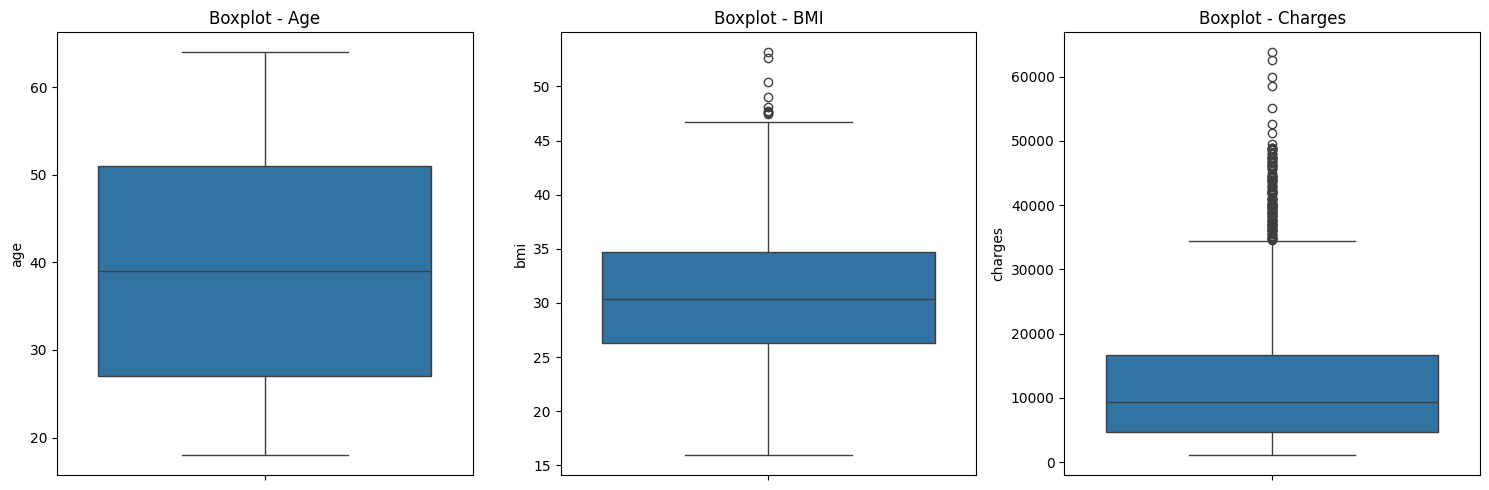

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize outliers using boxplots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['age'])
plt.title('Boxplot - Age')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['bmi'])
plt.title('Boxplot - BMI')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['charges'])
plt.title('Boxplot - Charges')

plt.tight_layout()
plt.show()


In [8]:
# Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

outliers_age = detect_outliers_iqr(df, 'age')
outliers_bmi = detect_outliers_iqr(df, 'bmi')
outliers_charges = detect_outliers_iqr(df, 'charges')

print("Outliers in Age:", len(outliers_age))
print("Outliers in BMI:", len(outliers_bmi))
print("Outliers in Charges:", len(outliers_charges))


Outliers in Age: 0
Outliers in BMI: 9
Outliers in Charges: 139


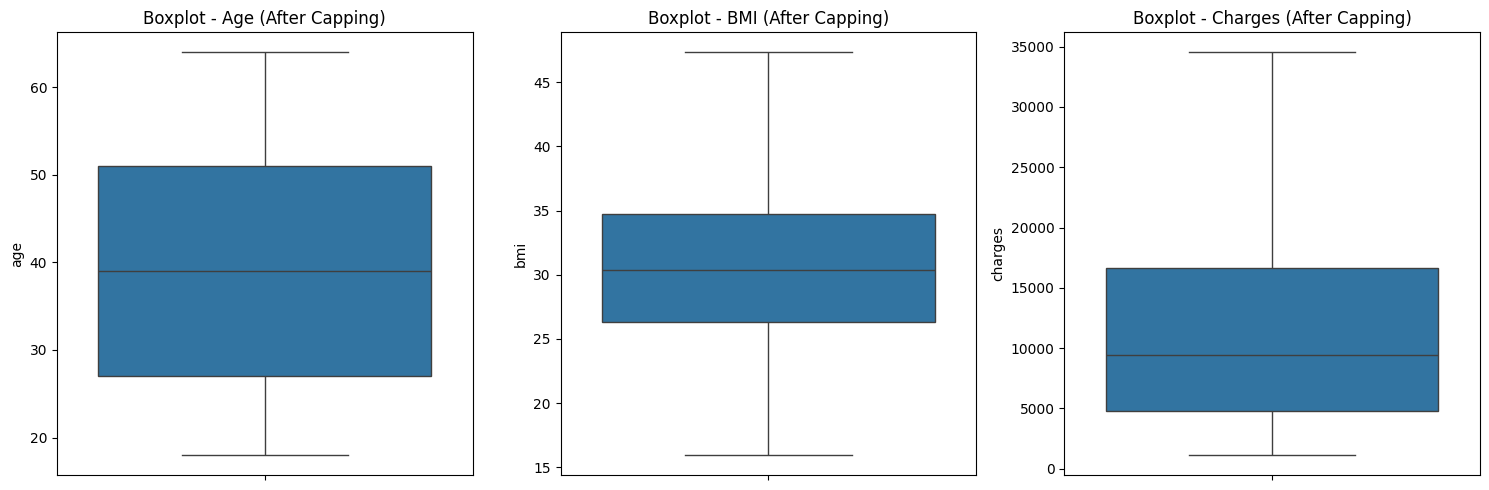

In [9]:
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])
    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])

# Apply capping to numerical columns
cap_outliers(df, 'age')
cap_outliers(df, 'bmi')
cap_outliers(df, 'charges')

# Check again with boxplot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=df['age'])
plt.title('Boxplot - Age (After Capping)')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['bmi'])
plt.title('Boxplot - BMI (After Capping)')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['charges'])
plt.title('Boxplot - Charges (After Capping)')

plt.tight_layout()
plt.show()


In [10]:
df.shape

(1337, 7)

#### Preparing X and Y variables

In [11]:
X = df.drop(columns=['charges'],axis=1)

In [12]:
X.head()

,age,sex,bmi,children,smoker,region
0,19.0,female,27.900,0,yes,southwest
1,18.0,male,33.770,1,no,southeast
2,28.0,male,33.000,3,no,southeast
3,33.0,male,22.705,0,no,northwest
4,32.0,male,28.880,0,no,northwest


In [13]:
print("Categories in 'sex' variable:     ",end=" " )
print(df['sex'].unique())

print("Categories in 'smoker' variable:  ",end=" ")
print(df['smoker'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(df['region'].unique())


Categories in 'sex' variable:      ['female' 'male']
Categories in 'smoker' variable:   ['yes' 'no']
Categories in'parental level of education' variable: ['southwest' 'southeast' 'northwest' 'northeast']


In [14]:
y = df['charges']

In [15]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1337, dtype: float64

# Apply Transformations

In [16]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer

# Define categorical and numerical features
cat_features = ["sex", "smoker", "region"]
num_features = ["age", "bmi", "children"]

# Define the preprocessor
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(), cat_features),
    # ("num", StandardScaler(), num_features)
    ("num", PowerTransformer(method='yeo-johnson', standardize=True), num_features)
])



In [17]:
print("Skewness before Transformation:", y.skew())

Skewness before Transformation: 1.0846971962484675


In [18]:
pt_y = PowerTransformer(method='yeo-johnson', standardize=True)

# Transform and convert back to a Pandas Series
y_transformed = pd.Series(pt_y.fit_transform(y.values.reshape(-1, 1)).flatten())

# Compute skewness
print("Skewness After Transformation:", y_transformed.skew())

    

Skewness After Transformation: -0.0286732014630139


In [19]:
# Fit the preprocessor to the training data

X = preprocessor.fit_transform(X)



In [20]:
X.shape

(1337, 11)

 # separate dataset into train and test

In [21]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((1069, 11), (268, 11))

#### Create an Evaluate Function to give all metrics after model Training

In [22]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

# Model Training

In [23]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold Cross Validation

models = {
    "Linear Regression": LinearRegression(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor(),
    'Support Vector Machine': SVR()
}


model_list = []
r2_list = []
cv_r2_list = []

for name, model in models.items():
    print(f"Training {name}...")

    # Fit the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate on Train/Test Split
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    # Perform Cross-Validation
    cv_scores = cross_val_score(model, X_test, y_test, scoring='r2', cv=kf, n_jobs=-1)
    mean_cv_r2 = np.mean(cv_scores)

    # Store Results
    model_list.append(name)
    r2_list.append(model_test_r2)
    cv_r2_list.append(mean_cv_r2)
    
    # Print Results
    
    print(f"{name} - Model performance for Training set")
    print(f"- RMSE: {model_train_rmse:.4f}")
    print(f"- MAE: {model_train_mae:.4f}")
    print(f"- R2 Score: {model_train_r2:.4f}\n")
    
    print(f"{name} - Model performance for Test set")
    print(f"- RMSE: {model_test_rmse:.4f}")
    print(f"- MAE: {model_test_mae:.4f}")
    print(f"- R2 Score: {model_test_r2:.4f}")
    
    print(f"{name} - Cross-Validation R2 Scores: {cv_scores}")
    print(f"{name} - Mean R2 (CV): {mean_cv_r2:.4f}")
    
    print('=' * 40)
    print('\n')

# Create DataFrame for Comparison
results_df = pd.DataFrame({
    'Model': model_list,
    'Test R2 (Hold-out)': r2_list,
    'Mean R2 (Cross-Validation)': cv_r2_list
})

# Sort by CV Score
results_df = results_df.sort_values(by='Mean R2 (Cross-Validation)', ascending=False)



Training Linear Regression...
Linear Regression - Model performance for Training set
- RMSE: 0.5064
- MAE: 0.3265
- R2 Score: 0.7385

Linear Regression - Model performance for Test set
- RMSE: 0.4375
- MAE: 0.2956
- R2 Score: 0.8220
Linear Regression - Cross-Validation R2 Scores: [0.84324223 0.79606151 0.81964013 0.74089179 0.82640554]
Linear Regression - Mean R2 (CV): 0.8052


Training K-Neighbors Regressor...
K-Neighbors Regressor - Model performance for Training set
- RMSE: 0.4158
- MAE: 0.2552
- R2 Score: 0.8238

K-Neighbors Regressor - Model performance for Test set
- RMSE: 0.4651
- MAE: 0.3035
- R2 Score: 0.7989
K-Neighbors Regressor - Cross-Validation R2 Scores: [0.70516804 0.70033169 0.7356876  0.53205685 0.7367375 ]
K-Neighbors Regressor - Mean R2 (CV): 0.6820


Training Decision Tree...
Decision Tree - Model performance for Training set
- RMSE: 0.0000
- MAE: 0.0000
- R2 Score: 1.0000

Decision Tree - Model performance for Test set
- RMSE: 0.5935
- MAE: 0.2604
- R2 Score: 0.67

In [24]:
# Display Results
results_df

,Model,Test R2 (Hold-out),Mean R2 (Cross-Validation)
4,CatBoosting Regressor,0.843993,0.834140
6,Support Vector Machine,0.877715,0.832967
3,Random Forest Regressor,0.837709,0.823401
0,Linear Regression,0.822016,0.805248
5,AdaBoost Regressor,0.785257,0.773619
2,Decision Tree,0.672463,0.688017
1,K-Neighbors Regressor,0.798860,0.681996


### Results

In [25]:
model_r2_df = pd.DataFrame(list(zip(model_list, r2_list, cv_r2_list)), columns=['Model Name', 'R2_Score', 'CV_R2_score']).sort_values(by=["CV_R2_score"],ascending=False)
model_r2_df

,Model Name,R2_Score,CV_R2_score
4,CatBoosting Regressor,0.843993,0.834140
6,Support Vector Machine,0.877715,0.832967
3,Random Forest Regressor,0.837709,0.823401
0,Linear Regression,0.822016,0.805248
5,AdaBoost Regressor,0.785257,0.773619
2,Decision Tree,0.672463,0.688017
1,K-Neighbors Regressor,0.798860,0.681996


In [26]:
import pickle

# # Assume the best model has been identified
# best_model_index = r2_list.index(max(cv_r2_list))  # Find index of the best R2 score
# best_model_name = model_list[best_model_index]  # Get the name of the best model
# best_model = models[best_model_name]  # Retrieve the best model instance

best_model_name = model_r2_df.iloc[0, 0] # Get the name of the best model']
best_model_score = model_r2_df.iloc[0, 2]
# Save the trained model
# with open('best_model.pkl', 'wb') as file:
#     pickle.dump(best_model, file)

print(f"The best model '{best_model_name}' with R2 score: {best_model_score}.")


The best model 'CatBoosting Regressor' with R2 score: 0.8341402377698541.


# Support Vector Regressor visualization

In [27]:
# Fit the model
final_model = SVR()
final_model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_score = r2_score(y_train, y_train_pred)*100
print(" Accuracy of the model on training is %.2f" %train_score)

test_score = r2_score(y_test, y_test_pred)*100
print(" Accuracy of the model on test is %.2f" %test_score)

 Accuracy of the model on training is 81.68
 Accuracy of the model on test is 87.77


### SVR Visualization

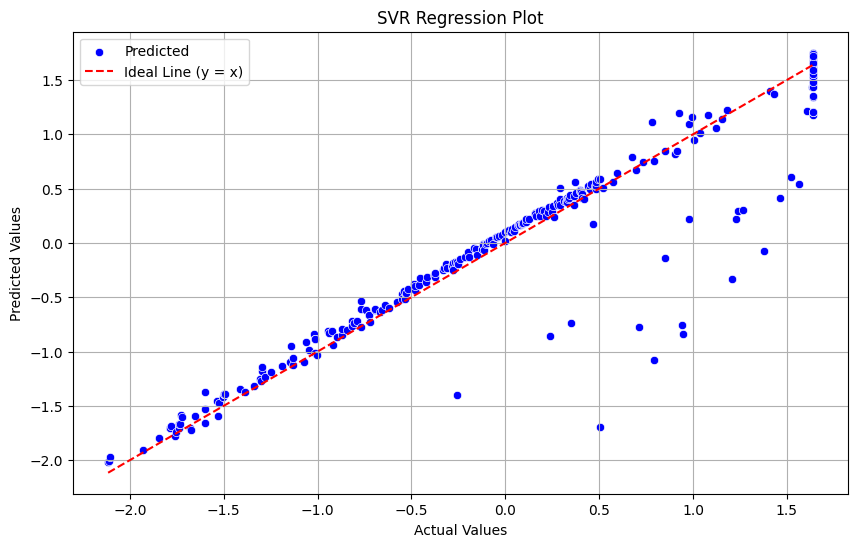

In [29]:
# Convert to numpy array
y_test_array = np.array(y_test)
y_test_pred_array = np.array(y_test_pred)

# Sort the data for smoother plots
sorted_indices = np.argsort(y_test_array)
y_test_sorted = y_test_array[sorted_indices]
y_test_pred_sorted = y_test_pred_array[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for actual vs predicted
sns.scatterplot(x=y_test_sorted, y=y_test_pred_sorted, color='blue', label='Predicted')

# Line plot for perfect prediction
plt.plot(y_test_sorted, y_test_sorted, color='red', linestyle='--', label='Ideal Line (y = x)')

plt.title('SVR Regression Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


# Hyperparameter Tuning for `SVR`

### usning RandomizedSearchCV

In [35]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
import time

# Define the reduced parameter grid
param_grid = {
    'kernel': ['rbf', 'linear'],  # Focus on two key kernels
    'C': [0.1, 1, 10],  # Fewer C values
    'epsilon': [0.01, 0.1, 0.5],  # Limited epsilon options
    'gamma': ['scale', 'auto', 0.1, 1]  # Reduced gamma options
}

# Initialize SVR model
svr = SVR()

# Perform RandomizedSearchCV with optimized parameters
random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_grid,
    n_iter=30,  # Reduced iterations
    scoring='r2',
    cv=3,  # Fewer cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Monitor time
start_time = time.time()

# Fit to the data
random_search.fit(X_train, y_train)

end_time = time.time()

# Best hyperparameters
print("Best Hyperparameters: ", random_search.best_params_)

# Best model
best_svr = random_search.best_estimator_

# Predictions using the best model
y_train_pred = best_svr.predict(X_train)
y_test_pred = best_svr.predict(X_test)

# Calculate R2 scores
train_score = r2_score(y_train, y_train_pred) * 100
test_score = r2_score(y_test, y_test_pred) * 100

print("Accuracy on Training Set: %.2f" % train_score)
print("Accuracy on Test Set: %.2f" % test_score)
print("Time taken (minutes): %.2f" % ((end_time - start_time) / 60))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Hyperparameters:  {'kernel': 'rbf', 'gamma': 'auto', 'epsilon': 0.1, 'C': 1}
Accuracy on Training Set: 81.08
Accuracy on Test Set: 87.97
Time taken (minutes): 0.03


### using GridSearchCV

In [ ]:


# # Define the parameter grid
# param_grid = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'C': [0.1, 1, 10, 100],
#     'epsilon': [0.01, 0.1, 0.5, 1],
#     'gamma': ['scale', 'auto', 0.1, 1, 10]
# }

# # Initialize SVR model
# svr = SVR()

# # Perform GridSearchCV
# grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, 
#                            scoring='r2', cv=5, verbose=2, n_jobs=-1)

# # Fit to the data
# grid_search.fit(X_train, y_train)

# # Best hyperparameters
# print("Best Hyperparameters: ", grid_search.best_params_)

# # Best model
# best_svr = grid_search.best_estimator_

# # Predictions using the best model
# y_train_pred = best_svr.predict(X_train)
# y_test_pred = best_svr.predict(X_test)

# # Calculate R2 scores
# train_score = r2_score(y_train, y_train_pred) * 100
# test_score = r2_score(y_test, y_test_pred) * 100

# print("Accuracy on Training Set: %.2f" % train_score)
# print("Accuracy on Test Set: %.2f" % test_score)


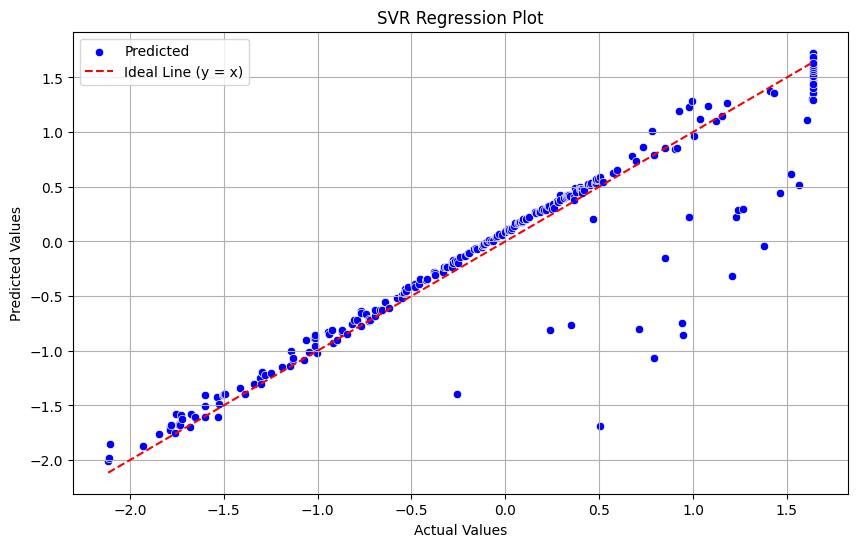

In [36]:
# Convert to numpy array
y_test_array = np.array(y_test)
y_test_pred_array = np.array(y_test_pred)

# Sort the data for smoother plots
sorted_indices = np.argsort(y_test_array)
y_test_sorted = y_test_array[sorted_indices]
y_test_pred_sorted = y_test_pred_array[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot for actual vs predicted
sns.scatterplot(x=y_test_sorted, y=y_test_pred_sorted, color='blue', label='Predicted')

# Line plot for perfect prediction
plt.plot(y_test_sorted, y_test_sorted, color='red', linestyle='--', label='Ideal Line (y = x)')

plt.title('SVR Regression Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


# Save the best model to a .pkl file


In [37]:

# Create the pipeline with the preprocessor and regressor

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # The preprocessor for feature transformations
    ('regressor', best_svr) 
])

# Save the entire pipeline to a .joblib file
joblib.dump(model_pipeline, 'model_pipeline.joblib')

print("Pipeline saved successfully to 'model_pipeline.joblib'")


Pipeline saved successfully to 'model_pipeline.joblib'
